In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math
np.random.seed(20170306)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Base Random Forest Model

In [2]:
# EDA
data = pd.read_csv("breast_cancer.csv")
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [3]:
# Remove trivial features & setting predict feature
data = data.drop(['Unnamed: 0', 'id number'], axis=1)
y = data.pop("malignant")
data.describe()

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.440629,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.665507,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [4]:
# Split Test and Training Sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

In [5]:
# Grid Search for hyperparameter optimization
n_estimators = [100,200,300,400,500]
max_features = ['auto', 'sqrt', 'log2']
min_samples_split = [1,2,3,4,5,6,7,8,9,10]

rfc = RandomForestClassifier(n_jobs=1)
# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [6]:
estimator.fit(X_train, y_train)
best_rfc = estimator.best_estimator_
best_rfc
best_rfc_predict = best_rfc.predict(X_test)

### Base Model Performance

In [7]:
# Accuracy
base_accuracy = accuracy_score(y_test, best_rfc_predict)
print("Accuracy: ", base_accuracy)

Accuracy:  0.964285714286


In [8]:
# Precision & Recall
print(classification_report(y_test, best_rfc_predict))


             precision    recall  f1-score   support

          0       0.97      0.98      0.97        95
          1       0.95      0.93      0.94        45

avg / total       0.96      0.96      0.96       140



In [9]:
# AUC
base_roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print("AUC Score: ", base_roc)

AUC Score:  0.99649122807


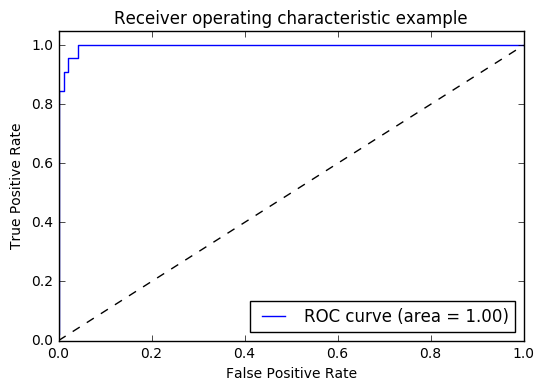

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % base_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### K-Fold Cross Validation Model

In [11]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)
scores

array([ 0.92957746,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  0.97142857,  0.98571429,  0.98550725,  1.        ])

In [12]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print ("Score is %f +/- %f" % (mean_score, ci))
print ('95 percent confidence interval for Score is %f and %f' % (lower_bound, upper_bound))

Score is 0.970080 +/- 0.018412
95 percent confidence interval for Score is 0.951668 and 0.988492


### Conclusion and Final Analysis
> Base Model (Single Holdout AUC)
+ AUC Score:  0.99649122807

> K-Fold Cross Validation
+ Cross Validation Score: 0.970059 +/- 0.018412 or (0.951668, 0.988492)

Clearly the AUC from the Single Holdout model quantifies are higher performance if directly with the Cross Validation Score (if those two are even directly comparable); however, the base model may suffer from overfitting indicated by suspiciously high perforance in Accuracy.  It is possible that the 20% holdout used may not be representative of the entire population and/or may not contain specialized edge cases which are critical in determining predictive performance.  By using K-Fold Cross Validation, we minimize the likelihood of this by using the entire dataset to both train and test into an aggregate average score of 0.97 +/- 0.017827

Digging further into the Precision and Recall figures for the base model, we see that the rate of False Positives most likely unsatisfactory for medical diagnosis purposes; otherwise said, a 3% false diagnosis of malignant is most likely not appropriate and thus we must further refine the model to increase both precision and recall.